In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, Linear
from flows.config import floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.02
m1 = 0.
s0 = 0.8
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params, dtype=floatX)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)

In [3]:
params.shape, params[0,0,0]

((32, 3, 4), 0.3771481309859945)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X) + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 1.93464234e-01, -4.96744938e-01,  1.03272322e+00],
        [ 1.30582349e+00, -3.38712970e-01,  2.54924379e+00],
        [ 3.54793064e+00,  2.00706351e-01,  3.81636480e+00],
        [ 5.46477434e+00,  1.67773360e-01,  4.14483884e+00],
        [ 6.76998010e+00, -7.43796558e-01,  4.55371921e+00],
        [ 9.05670141e+00, -2.02167447e+00,  6.68942972e+00],
        [ 1.35873228e+01, -2.39969183e+00,  1.11061538e+01],
        [ 2.10607159e+01, -1.53600028e+00,  1.68678718e+01],
        [ 3.07321303e+01, -9.05742505e-01,  2.08284498e+01],
        [ 3.83863277e+01, -2.60555785e+00,  2.38206244e+01],
        [ 4.80661560e+01, -6.36694919e+00,  3.09427547e+01],
        [ 6.42878562e+01, -1.13100908e+01,  4.60193039e+01],
        [ 9.54503604e+01, -1.79132967e+01,  7.28590982e+01],
        [ 1.51942657e+02, -2.42772538e+01,  1.15330651e+02],
        [ 2.28657466e+02, -3.41147675e+01,  1.73227902e+02],
        [ 3.44773865e+02, -5.24379264e+01,  2.60218099e+02],
        [ 5.08402881e+02

In [7]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
conf = [Linear(dim=n*dim[0]*dim[1])]

output_flow = DFlow(conf)

In [8]:
output_flow.output

<tf.Tensor 'LinFlow/add:0' shape=(1, 384) dtype=float64>

In [9]:
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [10]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs, mean=True)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_5:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred, full_reduce=True, mean=True)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_98:0' shape=() dtype=float64>

In [18]:
ent = output_flow.logdens

In [19]:
ent

<tf.Tensor 'sub_1:0' shape=(1,) dtype=float64>

In [20]:
loss = -logl/(n*dim[0]*dim[1]) + (ent - prior)/(xs.shape[1]*xs.shape[2])

In [21]:
opt1 = tf.train.AdamOptimizer(0.0001).minimize(loss)
opt2 = tf.train.GradientDescentOptimizer(0.000001).minimize(loss)

In [22]:
opt = opt1

In [23]:
sess = tf.InteractiveSession()

In [24]:
tf.global_variables_initializer().run()

In [25]:
logl.eval(), ent.eval()[0], prior.eval()

(-14081297653588.31, -578.5550623230597, -2234.866733859692)

In [26]:
stage = 0

In [27]:
for stage in range(stage, stage+60):
    for _ in range(900):
        l, _ = sess.run([loss, opt], {phase:True})
    print(stage, l)

0 [2.46477329e+10]
1 [3.10063711e+10]
2 [3.67741967e+10]
3 [2.1644193e+10]
4 [2.18753767e+10]
5 [1.71303477e+10]
6 [1.94384723e+10]
7 [2.63658436e+10]
8 [2.29759291e+10]
9 [1.56636868e+10]
10 [1.3006916e+10]
11 [2.02220879e+10]
12 [1.30740606e+10]
13 [1.48352496e+10]
14 [1.06273037e+10]
15 [1.08857507e+10]
16 [1.45757381e+10]
17 [1.14995954e+10]
18 [1.11932901e+10]
19 [1.23754014e+10]
20 [1.16901498e+10]
21 [1.07398909e+10]
22 [1.21994267e+10]
23 [1.17351334e+10]
24 [1.38443444e+10]
25 [1.12712715e+10]
26 [1.51501783e+10]
27 [1.0160088e+10]
28 [9.48656019e+09]
29 [9.68624408e+09]
30 [9.25809709e+09]
31 [9.82646257e+09]
32 [1.44232964e+10]
33 [9.31047697e+09]
34 [9.69171707e+09]
35 [1.20397355e+10]
36 [9.33298913e+09]
37 [9.61621259e+09]
38 [9.93018288e+09]
39 [8.91170127e+09]
40 [9.11362731e+09]
41 [9.1186882e+09]
42 [8.81167872e+09]
43 [9.15857577e+09]
44 [9.40493951e+09]
45 [9.09081495e+09]
46 [9.26492428e+09]
47 [9.05159704e+09]
48 [9.2575175e+09]
49 [8.84531933e+09]
50 [8.82501968e

In [28]:
out = tf.reshape(outputs, [n, 3, 4])

In [29]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append([s[3,2,3], s[4,2,3]])
samples = np.array(samples)

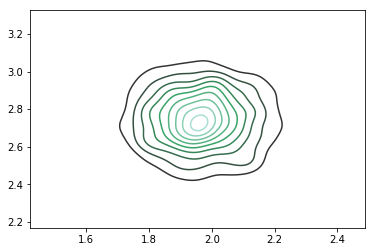

In [30]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [31]:
params[0,2,3]

0.7935568178741423

In [32]:
samples[:,0].mean()

1.9614602161430144

In [43]:
params[6]

array([[ 0.43478002, -0.99567902,  1.17428307, -0.2315298 ],
       [-0.5733243 ,  0.65228204,  0.74914674, -0.59986248],
       [ 0.05501751, -1.8621779 ,  0.96046363,  0.84575653]])